In [3]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [4]:

import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


In [5]:
import cv2                
import matplotlib.pyplot as plt                                                     

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Number of faces detected: 1


<Figure size 640x480 with 1 Axes>

In [6]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [7]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

##  Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

face_detector_accuracy_human = np.mean(list(map(face_detector, human_files_short)))
face_detector_accuracy_dog   = np.mean(list(map(face_detector,   dog_files_short)))

print("face_detector accuracy on humans: {}%".format(face_detector_accuracy_human * 100))
print("face_detector accuracy on dogs: {}%".format(face_detector_accuracy_dog * 100))

face_detector accuracy on humans: 99.0%
face_detector accuracy on dogs: 12.0%


In [8]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

In [9]:

from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [10]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

In [22]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

dog_detector_accuracy_human = np.mean(list(map(dog_detector, human_files_short)))
dog_detector_accuracy_dog   = np.mean(list(map(dog_detector,   dog_files_short)))

print("dog_detector accuracy on humans: {}%".format(dog_detector_accuracy_human * 100))
print("dog_detector accuracy on dogs: {}%".format(dog_detector_accuracy_dog * 100))

dog_detector accuracy on humans: 1.0%
dog_detector accuracy on dogs: 100.0%


In [13]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255         

100%|██████████| 836/836 [00:09<00:00, 86.98it/s] 


In [20]:

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

###   architecture.

input_shape = train_tensors.shape[1:]
output_categories = len(dog_names)

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(GlobalAveragePooling2D())
model.add(Dense(output_categories, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 28, 28, 64)        0         
__________

In [23]:

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:

from keras.callbacks import ModelCheckpoint

epochs=20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 176s 26ms/step - loss: 4.8837 - acc: 0.0105 - val_loss: 4.8685 - val_acc: 0.0108

Epoch 00001: val_loss improved from inf to 4.86848, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/20
6680/6680 [==============================] - 149s 22ms/step - loss: 4.8695 - acc: 0.0109 - val_loss: 4.8645 - val_acc: 0.0180

Epoch 00002: val_loss improved from 4.86848 to 4.86453, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/20
6680/6680 [==============================] - 142s 21ms/step - loss: 4.8545 - acc: 0.0148 - val_loss: 4.8432 - val_acc: 0.0168

Epoch 00003: val_loss improved from 4.86453 to 4.84325, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 4/20
6680/6680 [==============================] - 146s 22ms/step - loss: 4.8196 - acc: 0.0175 - val_loss: 4.8146 - val_acc: 0.0156

Epoch 00004: val_loss improved from 4.84325 to 4.81459, s

In [27]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [28]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 4.3062%


In [38]:
#To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning. In the following step, you will get a chance to use transfer learning to train your own CNN.

bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']



In [39]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


In [40]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [41]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=50, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 428us/step - loss: 12.0135 - acc: 0.1114 - val_loss: 10.1537 - val_acc: 0.1976

Epoch 00001: val_loss improved from inf to 10.15367, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 2/20
6680/6680 [==============================] - 2s 241us/step - loss: 8.8272 - acc: 0.2948 - val_loss: 8.4223 - val_acc: 0.3174

Epoch 00002: val_loss improved from 10.15367 to 8.42234, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 3/20
6680/6680 [==============================] - 2s 239us/step - loss: 7.7946 - acc: 0.4055 - val_loss: 8.1259 - val_acc: 0.3401

Epoch 00003: val_loss improved from 8.42234 to 8.12588, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 4/20
6680/6680 [==============================] - 2s 227us/step - loss: 7.3496 - acc: 0.4660 - val_loss: 7.7691 - val_acc: 0.3976

Epoch 00004: val_loss improved from 8.12588 to 7.76907, saving model to saved_

In [42]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

In [43]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 50.1196%


In [44]:
#Predict Dog Breed with the Model

def extract_VGG16(tensor):

	from keras.applications.vgg16 import VGG16, preprocess_input

	return VGG16(weights='imagenet', include_top=False).predict(preprocess_input(tensor))
def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [45]:

###  Write your algorithm.

def tmp_image_path():
    from uuid import uuid4 as uuid
    return '/tmp/' + str(uuid()) + '.png'

def capture_image():
    capture = cv2.VideoCapture(0)
    ret, img = capture.read()
    capture.release()

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

def capture_image_path():
    img = capture_img()
    img_path = tmp_image_path()
    print(img_path)
    return cv2.imwrite(img_path, img)

def show_image(img_path):
    #Get the image at path, in RGB format
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #There's an issue with pyplot displaying an old image
    #Re-importing the module here seems to fix that
    import matplotlib.pyplot as plt
    %matplotlib inline

    #Show image
    plt.imshow(img)
    plt.show()

def nature_image_path():
    import urllib.request as request

    #Get a random nature image
    url = 'http://lorempixel.com/300/300/nature'
    img_path = '/tmp/nature.png'

    with request.urlopen(url) as response, open(img_path, 'wb') as image_file:
        #Save downloaded image to temporary file
        image_file.write(response.read())

    return img_path

def predict_breed(img_path, is_dog=dog_detector, is_human=face_detector, predictor=VGG16_predict_breed):

    print(img_path)
    show_image(img_path)

    if is_dog(img_path):
        print('hello, dog!')
        prediction_str = 'this is a {}'

    elif is_human(img_path):
        print('hello, human!')
        prediction_str = 'you look like a {}'

    else:
        print('neither a dog, nor a human ¯\_(ツ)_/¯')
        return

    breed = predictor(img_path)
    print(prediction_str.format(breed))

    return breed

lfw\Cho_Myung-kyun\Cho_Myung-kyun_0001.jpg


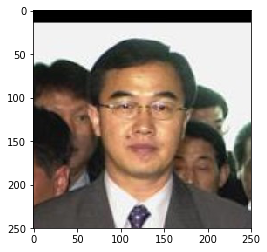

hello, human!
58892288/58889256 [==============================] - 548s 9us/step
you look like a Norwegian_lundehund


'Norwegian_lundehund'

In [46]:
predict_breed(random.choice(human_files))

dogImages/test\048.Chihuahua\Chihuahua_03448.jpg


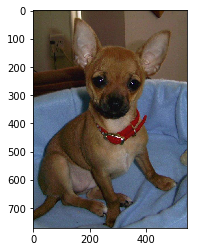

hello, dog!
this is a Cardigan_welsh_corgi


'Cardigan_welsh_corgi'

In [47]:
predict_breed(random.choice(test_files)) #Dog